# Illinois Bundleflower NIR Modeling

### Module Imports

In [22]:
import mlflow
import numpy as np
import polars as pl
import astartes as at
import matplotlib.pyplot as plt

from typing import Iterable

from mlflow.models import infer_signature
from itertools import compress
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

### Custom Functions and Classes

In [23]:
# Filter function to get rid of low quality spectra
def filter_spectra(X: np.ndarray, threshold: int) -> np.ndarray:
    """
    Takes a Numpy array and filters out any spectra with low spread between the minimum and maximum value of the spectra
    Returns a filtered Numpy array of spectra
    """
    spread = X.max(axis=1) - X.min(axis=1)
    idx = spread > threshold

    return X[idx], idx

def wavenumber_to_nm(X: Iterable):
    """ Convert Iterable wavenumber per cm to wavelength(nm)"""
    # Sort X from hi to lo
    X = sorted(list(X), reverse=True)
    # Convert from wavenumber/cm to wavelength(nm)
    nm = list(map(lambda x: 10**7 / float(x), X))
    
    return nm
    
def nm_to_wavenumber(X):
    """ Convert Iterable wavelength(nm) to wavenumber per cm """
    # Sort X from lo to hi
    X = sorted(list(X))
    # Convert from wavelength(nm) to wavenumber/cm
    wavenumber = list(map(lambda x: 1/(10**-7 * float(x)), X))

    return wavenumber

def error_fig(gt, preds, title, block=None):
    mapping = {
        'ward': 'red',
        'dairyland': 'blue'
    }
    fig, ax = plt.subplots()
    if block is not None:
        for block_name in np.unique(block):
            idx = [x == block_name for x in block]
            sub_preds = list(compress(preds, idx))
            sub_gt = list(compress(gt, idx))
            ax.scatter(sub_gt, sub_preds, color=mapping.get(block_name), alpha=0.6, label=block_name)
        ax.legend(loc="upper left", title="Wetchem origin")
    else:
        ax.scatter(gt, preds, color='blue', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel("Predictions")
    ax.axline((0, 0), slope=1, color='green', linestyle='--')

    min_val = min(gt.min(), preds.min())
    max_val = max(gt.max(), preds.max())

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    plt.close(fig)

    return fig

class EquidistantInterpolator(BaseEstimator):
    """
    Ascending sort and linearly interpolate data with equidistant wavelength steps
    """

    def __init__(self, lambda_nm: np.ndarray=None):
        self.lambda_nm = lambda_nm

    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        
        sort_idx = np.argsort(self.lambda_nm)
        lambda_nm = self.lambda_nm[sort_idx]
        min_nm = np.min(lambda_nm)
        max_nm = np.max(lambda_nm)
        equi_nm = np.linspace(start=min_nm, stop=max_nm, num=len(lambda_nm))
        self.equidistant_lambda_nm = equi_nm

        X = X[:, sort_idx]
        self.transformed_X = np.array(
            [
                np.interp(
                    x=equi_nm,
                    xp=lambda_nm,
                    fp=row
                ) for row in X
            ]
        )
        
        return self.transformed_X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
        

class SavgolTransform(BaseEstimator):
    """
    Implement a Savitsky Golay filter as a preprocessing step
    Returns the filtered, derivitized data
    """    
    def __init__(self, window_length: int=10, polyorder: int=5, deriv: int=2):
        """ Initialize and allow keyword arguments to be passed """
        self.window_length=window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X=None, y=None):
        """ Not implemented, return self """
        return self

    def transform(self, X):
        """ Transform the X matrix of spectra with a Savgol filter according to initialized attributes """
        X_filtered = savgol_filter(
            x=X,
            window_length=self.window_length,
            polyorder=self.polyorder,
            deriv=self.deriv
        )
        return X_filtered

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)



### Read in Data

In [24]:
raw_1mm_spectra = pl.read_csv('../data/lumpkin_ibf_nir_spectra_1mm.csv')
raw_10mm_spectra = pl.read_csv('../data/lumpkin_ibf_nir_spectra_10mm.csv')
raw_wetchem = pl.read_csv('../data/lumpkin_ibf_wet_chemistry_results.csv', null_values='NA')
raw_yield = pl.read_csv("../data/lumpkin_ibf_forage_yield.csv")

In [25]:
# Print the first ten column names
print(raw_1mm_spectra.columns[:10])

['Sample Name', 'Device Id', 'Created At', 'Created By', '2549.999982425943', '2541.1764576690834', '2532.413784775524', '2523.711336406793', '2515.0684938180916', '2506.4846467116427']


In [26]:
raw_wetchem.head()

sample_name,material,lab,moisture_pct,dry_matter_pct,crude_protein_pct,adf_pct,ndf_pct,relative_feed_value,total_digestible_nutrients,nem_adf,neg_adf,nel_adf
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-101""","""ibf_stems_leaves""","""ward""",7.61,92.39,16.1,31.9,46.3,129.0,58.4,56.98,31.18,66.02
"""LMP-111""","""ibf_stems_leaves""","""ward""",8.19,91.81,15.8,38.1,55.0,100.0,53.8,49.84,24.61,58.69
"""LMP-117""","""ibf_stems_leaves""","""ward""",8.06,91.94,11.7,37.0,51.3,109.0,54.6,51.08,25.76,59.95
"""LMP-121""","""ibf_stems_leaves""","""ward""",8.42,91.58,11.7,33.2,46.5,126.0,57.4,55.48,29.81,64.46
"""LMP-124""","""ibf_stems_leaves""","""ward""",8.09,91.91,13.9,31.7,46.4,129.0,58.5,57.2,31.38,66.25


### Filter out low quality spectra for 1mm forage

In [27]:
# Get filter index for high quality spectra
raw_1mm_X = raw_1mm_spectra[:, 4:]
_, idx = filter_spectra(raw_1mm_X.to_numpy(), threshold=10)

# Split 'Sample Name' into 'sample_name' and 'rep'
cleaned_name_df = raw_1mm_spectra\
    .select(
        pl.col('Sample Name')\
        .str\
        .split('_')\
        .list\
        .to_struct("max_width", ['sample_name', 'rep'])
    ).unnest('Sample Name')

# Combine new name columns with spectra and filter
raw_1mm_spectra_df = pl.concat([cleaned_name_df, raw_1mm_spectra[:, 4:]], how='horizontal')\
    .filter(idx)

raw_1mm_spectra_df.head()

sample_name,rep,2549.999982425943,2541.1764576690834,2532.413784775524,2523.711336406793,2515.0684938180916,2506.4846467116427,2497.9591930930387,2489.4915391305026,2481.081099017007,2472.7272948351774,2464.4295564249164,2456.187321253681,2448.0000342893604,2439.8671478756805,2431.78812161009,2423.76242222406,2415.789523465751,2407.8689059849817,2400.0000572204603,2392.182471289214,2384.4156488781755,2376.6990971378737,2369.0323295781836,2361.414865966083,2353.8462322253827,2346.32596033837,2338.8535882493393,2331.428659769957,2324.050724486421,2316.7193376683836,2309.4340601795843,2302.194458390173,2295.000104090669,2287.8505744075333,2280.7454517203114,…,1445.669608483219,1442.8293939820198,1440.0003175736174,1437.1823138680538,1434.3753179862301,1431.5792655549267,1428.7940927018833,1426.019736050934,1423.2561327172014,1420.5032203023445,1417.760936889863,1415.0292210404543,1412.3080117874263,1409.5972486321605,1406.8968715396297,1404.2068209339657,1401.527037694077,1398.8574631493193,1396.198039075212,1393.5487076892061,1390.9094116464996,1388.2800940358989,1385.6606983757288,1383.051168609788,1380.4514491033503,1377.861484639211,1375.2812204137772,1372.7106020332021,1370.1495755095634,1367.5980872570829,1365.05608408839,1362.5235132108253,1360.000322222786,1357.4864591101118,1354.9818722425105,1352.4865103700236,1350.0003226195302
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-406""","""2""",48.845921,48.401282,48.032263,47.738447,47.521671,47.398642,47.42378,47.653012,48.148185,48.948272,50.046691,51.381578,52.845843,54.313639,55.670062,56.831118,57.744913,58.390245,58.799043,59.0061,59.055248,58.992922,58.864336,58.71217,58.577023,58.497532,58.507506,58.635899,58.884,59.230586,59.644633,60.095461,60.568994,61.080658,61.677915,…,76.771973,77.068295,77.408519,77.7579,78.111159,78.497619,78.968385,79.583636,80.352592,81.252759,82.234191,83.238226,84.217363,85.146974,86.023187,86.851452,87.628257,88.339288,88.96513,89.489179,89.912303,90.255693,90.552962,90.834943,91.1152,91.382132,91.60116,91.747552,91.818082,91.840548,91.866407,91.95143,92.131815,92.405098,92.726154,93.015502,93.209764
"""LMP-406""","""1""",48.990801,48.477955,48.034054,47.680215,47.431252,47.30371,47.340629,47.580447,48.074469,48.859796,49.936092,51.251702,52.708055,54.181812,55.553759,56.731717,57.656259,58.303462,58.709686,58.916857,58.974998,58.932587,58.83154,58.707415,58.592998,58.521553,58.526116,58.639565,58.871189,59.206799,59.619234,60.077771,60.564908,61.090763,61.69754,…,77.225275,77.373023,77.543442,77.775163,78.111212,78.582836,79.197564,79.942934,80.772543,81.651314,82.556807,83.48071,84.421706,85.373729,86.31615,87.212627,88.012828,88.682162,89.219617,89.64681,90.003548,90.33134,90.656891,90.982706,91.288968,91.543735,91.717793,91.817371,91.868962,91.914978,91.998418,92.147651,92.366662,92.633122,92.9062,93.13659,93.302278
"""LMP-172""","""2""",49.876259,49.455092,49.093952,48.790917,48.551411,48.398664,48.39412,48.599043,49.07836,49.873322,50.978912,52.333073,53.82558,55.324746,56.709072,57.889808,58.813897,59.463739,59.878377,60.098871,60.171917,60.141776,60.04745,59.924656,59.810212,59.744654,59.768715,59.919852,60.20155,60.584507,61.021852,61.465074,61.888635,62.309912,62.793934,…,77.276933,77.473948,77.709813,77.98699,78.322919,78.74437,79.274672,79.928644,80.682922,81.510893,82.389047,83.306047,84.26231,85.258773,86.280172,87.284995,88.200939,88.958666,89.531281,89.933558,90.221746,90.468851,90.732973,91.034329,91.352071,91.63976,91.852544,91.992876,92.09626,92.214767,92.388155,92.621519,92.881742,93.11483,93.275293,93.349254,93.384201
"""LMP-172""","""1""",50.084559,49.56703,49.111851,48.743245,48.480329,48.341666,48.36873,48.596709,49.07604,49.847224,50.9167,52.239185,53.717627,

### Filter out low quality spectra for 10mm forage

In [28]:
# Get filter index for high quality spectra
raw_10mm_X = raw_10mm_spectra[:, 4:]
_, idx = filter_spectra(raw_10mm_X.to_numpy(), threshold=10)

# Split 'Sample Name' into 'sample_name' and 'rep'
cleaned_name_df = raw_10mm_spectra\
    .select(
        pl.col('Sample Name')\
        .str\
        .split('_')\
        .list\
        .to_struct("max_width", ['sample_name', 'rep'])
    ).unnest('Sample Name')

# Combine new name columns with spectra and filter
raw_10mm_spectra_df = pl.concat([cleaned_name_df, raw_10mm_spectra[:, 4:]], how='horizontal')\
    .filter(idx)

raw_10mm_spectra_df.head()

sample_name,rep,2549.999982425943,2541.1764576690834,2532.413784775524,2523.711336406793,2515.0684938180916,2506.4846467116427,2497.9591930930387,2489.4915391305026,2481.081099017007,2472.7272948351774,2464.4295564249164,2456.187321253681,2448.0000342893604,2439.8671478756805,2431.78812161009,2423.76242222406,2415.789523465751,2407.8689059849817,2400.0000572204603,2392.182471289214,2384.4156488781755,2376.6990971378737,2369.0323295781836,2361.414865966083,2353.8462322253827,2346.32596033837,2338.8535882493393,2331.428659769957,2324.050724486421,2316.7193376683836,2309.4340601795843,2302.194458390173,2295.000104090669,2287.8505744075333,2280.7454517203114,…,1445.669608483219,1442.8293939820198,1440.0003175736174,1437.1823138680538,1434.3753179862301,1431.5792655549267,1428.7940927018833,1426.019736050934,1423.2561327172014,1420.5032203023445,1417.760936889863,1415.0292210404543,1412.3080117874263,1409.5972486321605,1406.8968715396297,1404.2068209339657,1401.527037694077,1398.8574631493193,1396.198039075212,1393.5487076892061,1390.9094116464996,1388.2800940358989,1385.6606983757288,1383.051168609788,1380.4514491033503,1377.861484639211,1375.2812204137772,1372.7106020332021,1370.1495755095634,1367.5980872570829,1365.05608408839,1362.5235132108253,1360.000322222786,1357.4864591101118,1354.9818722425105,1352.4865103700236,1350.0003226195302
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-325""","""4""",28.723079,28.41306,28.157065,27.958415,27.818174,27.744352,27.770982,27.938604,28.298815,28.892277,29.727668,30.768405,31.935544,33.127033,34.243643,35.209631,35.978343,36.533797,36.906799,37.12998,37.238542,37.263621,37.231417,37.166902,37.098998,37.062985,37.09657,37.235429,37.486006,37.825337,38.214574,38.612976,38.999023,39.387322,39.832621,…,57.889723,58.086134,58.32918,58.651296,59.094313,59.691127,60.450523,61.360449,62.373245,63.458348,64.604649,65.819652,67.115335,68.488373,69.905862,71.306958,72.61224,73.767505,74.770571,75.652017,76.461068,77.237927,77.993121,78.704602,79.333752,79.848547,80.245271,80.572459,80.884798,81.229639,81.629977,82.080837,82.559565,83.04275,83.518672,83.987142,84.453116
"""LMP-325""","""3""",28.876699,28.516545,28.211353,27.973385,27.810369,27.73139,27.765317,27.941426,28.302004,28.882773,29.693822,30.70562,31.848459,33.027218,34.14429,35.120242,35.901892,36.467124,36.844995,37.070423,37.182864,37.216866,37.198893,37.150651,37.095828,37.06511,37.094783,37.223298,37.463746,37.799037,38.19295,38.603362,39.004339,39.405274,39.857242,…,57.959465,58.200251,58.485862,58.837424,59.284942,59.854266,60.557413,61.399521,62.36171,63.438508,64.631081,65.938783,67.345673,68.810538,70.268443,71.647015,72.882587,73.965039,74.935609,75.847049,76.738775,77.611141,78.42114,79.104001,79.611777,79.946743,80.18085,80.435258,80.799883,81.305566,81.911198,82.524608,83.04894,83.432839,83.698503,83.936491,84.25663
"""LMP-456""","""2""",25.773073,25.419932,25.109301,24.854433,24.666232,24.556335,24.552152,24.678024,24.96812,25.450493,26.131605,26.985434,27.954142,28.960558,29.925055,30.77893,31.468579,31.96089,32.270631,32.426392,32.470121,32.444103,32.381474,32.30446,32.229499,32.174599,32.163339,32.226758,32.383644,32.631614,32.950875,33.310779,33.685686,34.071288,34.493596,…,50.417233,50.701981,51.074644,51.534904,52.077371,52.695642,53.385178,54.148566,54.983675,55.892048,56.872674,57.918321,59.012391,60.127243,61.225129,62.263727,63.197935,64.005411,64.692381,65.277602,65.787785,66.245432,66.660255,67.027512,67.333935,67.567384,67.729074,67.85169,67.977151,68.149439,68.399658,68.734611,69.133254,69.552801,69.944117,70.264302,70.513343
"""LMP-456""","""1""",25.831875,25.446762,25.113025,24.849642,24.66614,24.566899,24.569808,24.694078,24.974956,25.445824,26.119385,26

## Modeling Pipeline in MLFlow

In [29]:
# Separate out data with target wetchem
calib_1mm_df = raw_wetchem.join(raw_1mm_spectra_df, on='sample_name', how='inner')
calib_10mm_df = raw_wetchem.join(raw_10mm_spectra_df, on='sample_name', how='inner')

In [30]:
# Main model loop
# Set tracking URI for MLFlow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

forage_data_dict = {
    '1mm': calib_1mm_df,
    '10mm': calib_10mm_df
}

for forage_size, calib_df in forage_data_dict.items():
    # Create all of the correct data
    # Split out X and Y values for 1mm forage
    lambda_nm = list(map(lambda x: round(float(x), 2), calib_df[:, 14:].columns))
    calib_X = calib_df[:, 14:]
    calib_y = calib_df[:, 2:13]
    calib_names = calib_df['sample_name']
    target_names = calib_y.columns

    # Create Test/Train split using Kennard Stone Algorithm
    X_train, X_test, y_train, y_test = at.train_test_split(calib_X.to_numpy(), calib_y.to_numpy(), train_size=.7, test_size=.3)

    # Split 'lab' column from y_train and y_test
    lab_train = y_train[:, 0]
    lab_test = y_test[:, 0]
    
    # Reset y_train and y_test
    y_train = y_train[:, 1:].astype(float)
    y_test = y_test[:, 1:].astype(float)
        
    # Main modeling loop
    for i, name in enumerate(target_names[1:]):
        print(i, name)
        # Set the experiment name
        prefix_name = f"ibf_{name}"
        mlflow.set_experiment(prefix_name)
        
        with mlflow.start_run():
            # Set up pipeline for each experiment
            plsr = PLSRegression()
            params = {'n_components': [i for i in range(1,16)]}
            rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
        
            pipe = Pipeline([
                ('interp', EquidistantInterpolator()),
                ('savgol', SavgolTransform()),
                ('scaler', StandardScaler()),
                ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
            ])
        
            pipe.set_params(
                interp__lambda_nm=np.array(lambda_nm),
                savgol__window_length=15,
                savgol__polyorder=3,
                savgol__deriv=2,
                scaler__with_std=False,
            )
        
            # Get tmp data sets subset for complete observations (no Nan)
            train_idx = np.isfinite(y_train[:, i])
            tmp_X_train = X_train[train_idx]
            tmp_y_train = y_train[train_idx, i]
            tmp_labs_train = lab_train[train_idx].tolist()
        
            test_idx = np.isfinite(y_test[:, i])
            tmp_X_test = X_test[test_idx]
            tmp_y_test = y_test[test_idx, i]
            tmp_labs_test = lab_test[test_idx].tolist()
            
            # Fit the model using GridSearchCV
            pipe.fit(tmp_X_train, tmp_y_train)
    
            print(pipe.named_steps['plsr'].best_score_)
    
            # Get the best GridSearch params
            best_params = pipe.named_steps['plsr'].best_params_
    
            # Predict the train and test sets
            train_preds = pipe.predict(tmp_X_train)
            test_preds = pipe.predict(tmp_X_test)
    
            # Plot the model prediction errors
            train_fig = error_fig(tmp_y_train, train_preds, f"{prefix_name} Training error", block=tmp_labs_train)
            test_fig = error_fig(tmp_y_test, test_preds, f"{prefix_name} Testing error", block=tmp_labs_test)
    
            # Log the error figures
            mlflow.log_figure(train_fig, f"{prefix_name}_train_error.png")
            mlflow.log_figure(test_fig, f"{prefix_name}_test_error.png")
    
            # Calculate train and test RMSE        
            train_rmse = root_mean_squared_error(tmp_y_train, train_preds)
            test_rmse = root_mean_squared_error(tmp_y_test, test_preds)
    
            print(f"{prefix_name} train_rmse: {train_rmse}")
            print(f"{prefix_name} test_rmse: {test_rmse}")
            #Log outputs
            mlflow.log_params(best_params)
            mlflow.log_params({
                'experiment_name': prefix_name,
                'forage_size': forage_size,
            })
            mlflow.log_metrics(
                {
                    'train_rmse': train_rmse,
                    'test_rmse': test_rmse
                }
            )
            
            model_signature = infer_signature(model_input=tmp_X_test, model_output=tmp_y_test)
            
            mlflow.sklearn.log_model(pipe, f"{prefix_name}", signature=model_signature)
    
            # plt.plot([i for i in range(1, 16)], -pipe.named_steps['plsr'].cv_results_['mean_test_score'])
            # plt.show()
            # plt.close()

            # Run inference on all spectra
            if forage_size == '1mm':
                numpy_data = raw_1mm_spectra_df[:, 2:].to_numpy()
                metadata = raw_1mm_spectra_df[:, :2]
                print(numpy_data.shape)
                print(metadata.shape)
            else:
                numpy_data = raw_10mm_spectra_df[:, 2:].to_numpy()
                metadata = raw_10mm_spectra_df[:, :2]

                print(numpy_data.shape)
                print(metadata.shape)

            preds = pipe.predict(numpy_data)
            preds = pl.dataframe.DataFrame({'value': pl.Series(preds)})
            preds = pl.concat([metadata, preds], how='horizontal')

            preds.write_csv(f'../predictions/{prefix_name}_{forage_size}_predictions.csv')
            
                
        
        

0 moisture_pct
-2.881999977078601
ibf_moisture_pct train_rmse: 2.5574921212133344
ibf_moisture_pct test_rmse: 2.997487566566267
(588, 257)
(588, 2)
🏃 View run able-worm-579 at: http://127.0.0.1:5000/#/experiments/231096377611019980/runs/191cb3121b0e47b799c581ff1989914b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/231096377611019980
1 dry_matter_pct
-2.8819999770786
ibf_dry_matter_pct train_rmse: 2.5574921212133352
ibf_dry_matter_pct test_rmse: 2.9974875665662712
(588, 257)
(588, 2)
🏃 View run luxuriant-seal-255 at: http://127.0.0.1:5000/#/experiments/584546235502743612/runs/fecbadc238bf4673ba21e6d931cb44c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/584546235502743612
2 crude_protein_pct
-1.22825917153279
ibf_crude_protein_pct train_rmse: 1.0533267813045628
ibf_crude_protein_pct test_rmse: 1.159254043903828
(588, 257)
(588, 2)
🏃 View run mysterious-carp-436 at: http://127.0.0.1:5000/#/experiments/943103134373397241/runs/85efb7faa2e24b5d8b7433575a10206e
🧪 View

/home/bomeyering/.pyenv/versions/3.11.8/envs/nir_env/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.70, got 0.69. Requested test size of 0.30, got 0.31. 
  warn(


-2.730569078595445
ibf_moisture_pct train_rmse: 2.6366384544801345
ibf_moisture_pct test_rmse: 2.738963208334845
(632, 257)
(632, 2)
🏃 View run bouncy-lark-74 at: http://127.0.0.1:5000/#/experiments/231096377611019980/runs/3e4232ca4bce43f2af7ff34ac592f03e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/231096377611019980
1 dry_matter_pct
-2.7305690785954453
ibf_dry_matter_pct train_rmse: 2.6366384544801345
ibf_dry_matter_pct test_rmse: 2.738963208334847
(632, 257)
(632, 2)
🏃 View run brawny-ram-351 at: http://127.0.0.1:5000/#/experiments/584546235502743612/runs/dbf6883e648247a9b807b34a4584247f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/584546235502743612
2 crude_protein_pct
-1.050904414804079
ibf_crude_protein_pct train_rmse: 0.9065511930540788
ibf_crude_protein_pct test_rmse: 1.9566097419164068
(632, 257)
(632, 2)
🏃 View run valuable-penguin-943 at: http://127.0.0.1:5000/#/experiments/943103134373397241/runs/64a572c6ee864815a78a4963249eba92
🧪 View experiment a

## Yield NIR Modeling

In [ ]:
yield_calib_df = raw_yield.join(raw_spectra_df, on='sample_name', how='inner')

In [ ]:
yield_calib_df

In [ ]:
# Split out X and Y values
yield_calib_X = yield_calib_df[:, 6:]
yield_calib_y = yield_calib_df[:, 4]
yield_calib_names = yield_calib_df['sample_name']

In [ ]:
# Create Train/Test split
X_train, X_test, y_train, y_test = at.train_test_split(yield_calib_X.to_numpy(), yield_calib_y.to_numpy(), train_size=.7, test_size=.3)

In [ ]:
prefix_name = f"ibf_yield"
mlflow.set_experiment(prefix_name)
    
with mlflow.start_run():
    # Set up pipeline for each experiment
    plsr = PLSRegression()
    params = {'n_components': [i for i in range(1,16)]}
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform()),
        ('scaler', StandardScaler()),
        ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
    ])
    
    pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        scaler__with_std=False,
    )
    
    # Get tmp data sets subset for complete observations (no Nan)
    train_idx = np.isfinite(y_train)
    tmp_X_train = X_train[train_idx]
    tmp_y_train = y_train[train_idx]
    
    test_idx = np.isfinite(y_test)
    tmp_X_test = X_test[test_idx]
    tmp_y_test = y_test[test_idx]
        
    # Fit the model using GridSearchCV
    pipe.fit(tmp_X_train, tmp_y_train)

    print(pipe.named_steps['plsr'].best_score_)

    # Get the best GridSearch params
    best_params = pipe.named_steps['plsr'].best_params_

    # Predict the train and test sets
    train_preds = pipe.predict(tmp_X_train)
    test_preds = pipe.predict(tmp_X_test)

    # Plot the model prediction errors
    train_fig = error_fig(tmp_y_train, train_preds, f"{prefix_name} Training error", block=tmp_labs_train)
    test_fig = error_fig(tmp_y_test, test_preds, f"{prefix_name} Testing error", block=tmp_labs_test)

    # Log the error figures
    mlflow.log_figure(train_fig, f"{prefix_name}_train_error.png")
    mlflow.log_figure(test_fig, f"{prefix_name}_test_error.png")

    # Calculate train and test RMSE        
    train_rmse = root_mean_squared_error(tmp_y_train, train_preds)
    test_rmse = root_mean_squared_error(tmp_y_test, test_preds)

    print(f"{prefix_name} train_rmse: {train_rmse}")
    print(f"{prefix_name} test_rmse: {test_rmse}")
    #Log outputs
    mlflow.log_params(best_params)
    mlflow.log_params({
        'experiment_name': prefix_name,
        'forage_size': '10mm'
    })
    mlflow.log_metrics(
        {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        }
    )
        
    model_signature = infer_signature(model_input=tmp_X_test, model_output=tmp_y_test)
        
    mlflow.sklearn.log_model(pipe, f"{prefix_name}", signature=model_signature)

    plt.plot([i for i in range(1, 16)], -pipe.named_steps['plsr'].cv_results_['mean_test_score'])
    plt.show()
    plt.close()

In [16]:
raw_10mm_spectra_df

sample_name,rep,2549.999982425943,2541.1764576690834,2532.413784775524,2523.711336406793,2515.0684938180916,2506.4846467116427,2497.9591930930387,2489.4915391305026,2481.081099017007,2472.7272948351774,2464.4295564249164,2456.187321253681,2448.0000342893604,2439.8671478756805,2431.78812161009,2423.76242222406,2415.789523465751,2407.8689059849817,2400.0000572204603,2392.182471289214,2384.4156488781755,2376.6990971378737,2369.0323295781836,2361.414865966083,2353.8462322253827,2346.32596033837,2338.8535882493393,2331.428659769957,2324.050724486421,2316.7193376683836,2309.4340601795843,2302.194458390173,2295.000104090669,2287.8505744075333,2280.7454517203114,…,1445.669608483219,1442.8293939820198,1440.0003175736174,1437.1823138680538,1434.3753179862301,1431.5792655549267,1428.7940927018833,1426.019736050934,1423.2561327172014,1420.5032203023445,1417.760936889863,1415.0292210404543,1412.3080117874263,1409.5972486321605,1406.8968715396297,1404.2068209339657,1401.527037694077,1398.8574631493193,1396.198039075212,1393.5487076892061,1390.9094116464996,1388.2800940358989,1385.6606983757288,1383.051168609788,1380.4514491033503,1377.861484639211,1375.2812204137772,1372.7106020332021,1370.1495755095634,1367.5980872570829,1365.05608408839,1362.5235132108253,1360.000322222786,1357.4864591101118,1354.9818722425105,1352.4865103700236,1350.0003226195302
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-325""","""4""",28.723079,28.41306,28.157065,27.958415,27.818174,27.744352,27.770982,27.938604,28.298815,28.892277,29.727668,30.768405,31.935544,33.127033,34.243643,35.209631,35.978343,36.533797,36.906799,37.12998,37.238542,37.263621,37.231417,37.166902,37.098998,37.062985,37.09657,37.235429,37.486006,37.825337,38.214574,38.612976,38.999023,39.387322,39.832621,…,57.889723,58.086134,58.32918,58.651296,59.094313,59.691127,60.450523,61.360449,62.373245,63.458348,64.604649,65.819652,67.115335,68.488373,69.905862,71.306958,72.61224,73.767505,74.770571,75.652017,76.461068,77.237927,77.993121,78.704602,79.333752,79.848547,80.245271,80.572459,80.884798,81.229639,81.629977,82.080837,82.559565,83.04275,83.518672,83.987142,84.453116
"""LMP-325""","""3""",28.876699,28.516545,28.211353,27.973385,27.810369,27.73139,27.765317,27.941426,28.302004,28.882773,29.693822,30.70562,31.848459,33.027218,34.14429,35.120242,35.901892,36.467124,36.844995,37.070423,37.182864,37.216866,37.198893,37.150651,37.095828,37.06511,37.094783,37.223298,37.463746,37.799037,38.19295,38.603362,39.004339,39.405274,39.857242,…,57.959465,58.200251,58.485862,58.837424,59.284942,59.854266,60.557413,61.399521,62.36171,63.438508,64.631081,65.938783,67.345673,68.810538,70.268443,71.647015,72.882587,73.965039,74.935609,75.847049,76.738775,77.611141,78.42114,79.104001,79.611777,79.946743,80.18085,80.435258,80.799883,81.305566,81.911198,82.524608,83.04894,83.432839,83.698503,83.936491,84.25663
"""LMP-456""","""2""",25.773073,25.419932,25.109301,24.854433,24.666232,24.556335,24.552152,24.678024,24.96812,25.450493,26.131605,26.985434,27.954142,28.960558,29.925055,30.77893,31.468579,31.96089,32.270631,32.426392,32.470121,32.444103,32.381474,32.30446,32.229499,32.174599,32.163339,32.226758,32.383644,32.631614,32.950875,33.310779,33.685686,34.071288,34.493596,…,50.417233,50.701981,51.074644,51.534904,52.077371,52.695642,53.385178,54.148566,54.983675,55.892048,56.872674,57.918321,59.012391,60.127243,61.225129,62.263727,63.197935,64.005411,64.692381,65.277602,65.787785,66.245432,66.660255,67.027512,67.333935,67.567384,67.729074,67.85169,67.977151,68.149439,68.399658,68.734611,69.133254,69.552801,69.944117,70.264302,70.513343
"""LMP-456""","""1""",25.831875,25.446762,25.113025,24.849642,24.66614,24.566899,24.569808,24.694078,24.974956,25.445824,26.119385,26

In [33]:
inf_pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform()),
        ('scaler', StandardScaler())
    ])

lambda_nm = list(map(lambda x: round(float(x), 2), raw_10mm_spectra_df[:, 2:].columns))

print(len(lambda_nm))

inf_pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        scaler__with_std=False,
    )

data = raw_10mm_spectra_df[:, 2:].to_numpy()
out = inf_pipe.fit_transform(data)

print(out.shape)


257
(632, 257)


In [35]:
import mlflow

model_uri = 'runs:/61eb85626060459ab8854bdaa70d87a4/ibf_total_digestible_nutrients'

# Replace INPUT_EXAMPLE with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
input_data = out

# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv",
)

MlflowException: Found 'uv' as env_manager, but the 'uv' command is not found in the PATH. Run `pip install uv` to install uv. See https://docs.astral.sh/uv/getting-started/installation for other installation methods. Alternatively, you can use 'virtualenv' or 'conda' as the environment manager, but note their performances are not as good as 'uv'.

In [36]:
!pip install uv

ERROR: Could not find a version that satisfies the requirement uv (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: No matching distribution found for uv


In [38]:
raw_1mm_spectra_df

sample_name,rep,2549.999982425943,2541.1764576690834,2532.413784775524,2523.711336406793,2515.0684938180916,2506.4846467116427,2497.9591930930387,2489.4915391305026,2481.081099017007,2472.7272948351774,2464.4295564249164,2456.187321253681,2448.0000342893604,2439.8671478756805,2431.78812161009,2423.76242222406,2415.789523465751,2407.8689059849817,2400.0000572204603,2392.182471289214,2384.4156488781755,2376.6990971378737,2369.0323295781836,2361.414865966083,2353.8462322253827,2346.32596033837,2338.8535882493393,2331.428659769957,2324.050724486421,2316.7193376683836,2309.4340601795843,2302.194458390173,2295.000104090669,2287.8505744075333,2280.7454517203114,…,1445.669608483219,1442.8293939820198,1440.0003175736174,1437.1823138680538,1434.3753179862301,1431.5792655549267,1428.7940927018833,1426.019736050934,1423.2561327172014,1420.5032203023445,1417.760936889863,1415.0292210404543,1412.3080117874263,1409.5972486321605,1406.8968715396297,1404.2068209339657,1401.527037694077,1398.8574631493193,1396.198039075212,1393.5487076892061,1390.9094116464996,1388.2800940358989,1385.6606983757288,1383.051168609788,1380.4514491033503,1377.861484639211,1375.2812204137772,1372.7106020332021,1370.1495755095634,1367.5980872570829,1365.05608408839,1362.5235132108253,1360.000322222786,1357.4864591101118,1354.9818722425105,1352.4865103700236,1350.0003226195302
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LMP-406""","""2""",48.845921,48.401282,48.032263,47.738447,47.521671,47.398642,47.42378,47.653012,48.148185,48.948272,50.046691,51.381578,52.845843,54.313639,55.670062,56.831118,57.744913,58.390245,58.799043,59.0061,59.055248,58.992922,58.864336,58.71217,58.577023,58.497532,58.507506,58.635899,58.884,59.230586,59.644633,60.095461,60.568994,61.080658,61.677915,…,76.771973,77.068295,77.408519,77.7579,78.111159,78.497619,78.968385,79.583636,80.352592,81.252759,82.234191,83.238226,84.217363,85.146974,86.023187,86.851452,87.628257,88.339288,88.96513,89.489179,89.912303,90.255693,90.552962,90.834943,91.1152,91.382132,91.60116,91.747552,91.818082,91.840548,91.866407,91.95143,92.131815,92.405098,92.726154,93.015502,93.209764
"""LMP-406""","""1""",48.990801,48.477955,48.034054,47.680215,47.431252,47.30371,47.340629,47.580447,48.074469,48.859796,49.936092,51.251702,52.708055,54.181812,55.553759,56.731717,57.656259,58.303462,58.709686,58.916857,58.974998,58.932587,58.83154,58.707415,58.592998,58.521553,58.526116,58.639565,58.871189,59.206799,59.619234,60.077771,60.564908,61.090763,61.69754,…,77.225275,77.373023,77.543442,77.775163,78.111212,78.582836,79.197564,79.942934,80.772543,81.651314,82.556807,83.48071,84.421706,85.373729,86.31615,87.212627,88.012828,88.682162,89.219617,89.64681,90.003548,90.33134,90.656891,90.982706,91.288968,91.543735,91.717793,91.817371,91.868962,91.914978,91.998418,92.147651,92.366662,92.633122,92.9062,93.13659,93.302278
"""LMP-172""","""2""",49.876259,49.455092,49.093952,48.790917,48.551411,48.398664,48.39412,48.599043,49.07836,49.873322,50.978912,52.333073,53.82558,55.324746,56.709072,57.889808,58.813897,59.463739,59.878377,60.098871,60.171917,60.141776,60.04745,59.924656,59.810212,59.744654,59.768715,59.919852,60.20155,60.584507,61.021852,61.465074,61.888635,62.309912,62.793934,…,77.276933,77.473948,77.709813,77.98699,78.322919,78.74437,79.274672,79.928644,80.682922,81.510893,82.389047,83.306047,84.26231,85.258773,86.280172,87.284995,88.200939,88.958666,89.531281,89.933558,90.221746,90.468851,90.732973,91.034329,91.352071,91.63976,91.852544,91.992876,92.09626,92.214767,92.388155,92.621519,92.881742,93.11483,93.275293,93.349254,93.384201
"""LMP-172""","""1""",50.084559,49.56703,49.111851,48.743245,48.480329,48.341666,48.36873,48.596709,49.07604,49.847224,50.9167,52.239185,53.717627,

## Sainfoin 10mm Selection

In [46]:
sainfoin_data = pl.read_csv('../data/sainfoin_10mm_nir_spectra.csv')
sainfoin_X = sainfoin_data[:, 4:].to_numpy()
sainfoin_y = sainfoin_data[:, 0].to_numpy()

pipe = Pipeline([
        ('interp', EquidistantInterpolator()),
        ('savgol', SavgolTransform())
        # ('scaler', StandardScaler())
        # ('plsr', GridSearchCV(estimator=plsr, param_grid=params, scoring=rmse_scorer))
    ])
    
pipe.set_params(
        interp__lambda_nm=np.array(lambda_nm),
        savgol__window_length=15,
        savgol__polyorder=3,
        savgol__deriv=2,
        # scaler__with_std=False,
    )

Pipeline(steps=[('interp',
                 EquidistantInterpolator(lambda_nm=array([2550.  , 2541.18, 2532.41, 2523.71, 2515.07, 2506.48, 2497.96,
       2489.49, 2481.08, 2472.73, 2464.43, 2456.19, 2448.  , 2439.87,
       2431.79, 2423.76, 2415.79, 2407.87, 2400.  , 2392.18, 2384.42,
       2376.7 , 2369.03, 2361.41, 2353.85, 2346.33, 2338.85, 2331.43,
       2324.05, 2316.72, 2309.43, 2302.19, 2295.  , 2287.85, 2280.75,
       2273.68, 2266...
       1454.26, 1451.38, 1448.52, 1445.67, 1442.83, 1440.  , 1437.18,
       1434.38, 1431.58, 1428.79, 1426.02, 1423.26, 1420.5 , 1417.76,
       1415.03, 1412.31, 1409.6 , 1406.9 , 1404.21, 1401.53, 1398.86,
       1396.2 , 1393.55, 1390.91, 1388.28, 1385.66, 1383.05, 1380.45,
       1377.86, 1375.28, 1372.71, 1370.15, 1367.6 , 1365.06, 1362.52,
       1360.  , 1357.49, 1354.98, 1352.49, 1350.  ]))),
                ('savgol', SavgolTransform(polyorder=3, window_length=15))])

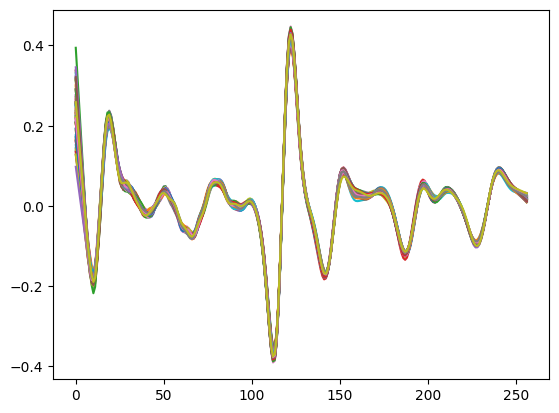

In [44]:
X = pipe.fit_transform(sainfoin_X)
plt.plot(X.T)
plt.show()
plt.close()

In [53]:
X_train, X_test, y_train, y_test = at.train_test_split(sainfoin_X, sainfoin_y, train_size=.26)

/home/bomeyering/.pyenv/versions/3.11.8/envs/nir_env/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.26, got 0.25. Requested test size of 0.74, got 0.75. 
  warn(


In [56]:
X_train.shape
y_train


array(['S2112_R5C3', 'S2112_R7C1', 'S2112_R6C4', 'S2112_R2C4',
       'S2112_R7C3', 'S2112_R16C4', 'S2112_R12C5', 'S2112_R1C5',
       'S2112_R8C5', 'S2112_R15C5', 'S2112_R8C3', 'S2112_R11C2',
       'S2112_R8C4', 'S2112_R11C4', 'S2112_R13C4', 'S2112_R16C1',
       'S2112_R15C3', 'S2112_R12C4', 'S2112_R3C1', 'S2112_R5C4'],
      dtype=object)

In [57]:
df = pl.dataframe.DataFrame({'sample_name': pl.Series(y_train)})


In [58]:
df.write_csv('sainfoin_wetchem_selections.csv')